# EEG Data Analysis

<img src="https://www.researchgate.net/profile/Jose-Del-R-Millan/publication/330340445/figure/fig1/AS:714229665517574@1547297030604/64-EEG-Electrodes-layout-extended-10-20-international.ppm" height="400px">

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import os,sys,time
import datetime
import shutil
import re
import json
import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import IPython
import ipywidgets as widgets
from IPython.display import Markdown, display
import mne
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs, create_eog_epochs)

SRC_PATH = "/Users/eliot/Documents/projects/brainkt-expe/src"
sys.path.append(SRC_PATH)
from eeg_base import _read_participant_eeg, add_ref, _pre_ica_filter, add_annotations, list_bridged, plot_distrib_edistances, plot_electrical_distance_matrix_os
from textgrid_utils import read_tier

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 150)
#?pd.set_option

In [4]:
#!pip install mne-features
from mne_features.univariate import compute_hurst_exp
from mne_icalabel.gui import label_ica_components
from mne_icalabel import label_components

In [5]:
mne.viz.set_browser_backend('qt')#'matplotlib')


Using qt as 2D backend.


In [6]:
eeg_folder = '../data/eeg-aligned/'
oeeg_folder = '../data/eeg-task-cleaned'
aeeg_folder = '../data/eeg-analysis'
eeg_files = [x for x in sorted(os.listdir(eeg_folder)) if '-raw.fif' in x]
transcript_folder = "../data/transcript/csv_wav2vec"
REPLACE_IPU_ANNOTATIONS = False
markers = pd.read_csv("../data/video/markers_from_video_start.csv")
markers.head(1)

file  Start  Watch p1  Watch p2  Clap  Start Task 1  End Task 1  \
0  221116_CGLS    0.0      3.04     12.52  52.2         62.84     1016.16   

   End Task 2     Stop  Actual End Task 1  
0     1889.76  1891.88                NaN

## Analysis

In [7]:
print(sorted([x for x in os.listdir(oeeg_folder) if 'edf' in x]))

['bkt-221118-GDNF-p2-t1-ica.edf']


In [8]:
file_selector = widgets.Dropdown(options = eeg_files, description="Which file?")
file_selector

Dropdown(description='Which file?', options=('bkt-221116-CGLS-p1-raw.fif', 'bkt-221116-CGLS-p2-raw.fif', 'bkt-…

### Read main file, locate bad electrodes and annotate them:

In [74]:
%%capture
# read
cfile = file_selector.value
_, date, group, part, _ = cfile.split('-')
mark = markers[markers.file == f"{date}_{group}"].iloc[0]
p1 = _read_participant_eeg(date, group, int(part[1]))
# processing


In [75]:
### reading IPU data for annotation
partl = group[(int(part[1]))*2:(int(part[1]))*2+2]
opart = 2 - int(part[1])
oparto = group[(opart-1)*2:(opart-1)*2+2]
# loading
p1_spk = pd.read_csv(os.path.join(transcript_folder, f"bkt-{date}-{group}-mono{int(part[1])-1}.wav.csv"), na_values=['#'], header=None, names=['IPUs', 'start', 'stop', 'text']
    ).drop(columns=['IPUs']).dropna()
p2_spk = pd.read_csv(os.path.join(transcript_folder, f"bkt-{date}-{group}-mono{opart}.wav.csv"), na_values=['#'], header=None, names=['IPUs', 'start', 'stop', 'text']
    ).drop(columns=['IPUs']).dropna()
p1_spk.head(2)

start   stop         text
1  0.032  0.544  je ou juste
3  5.664  6.720           ok

In [72]:
#x = p1.annotations.to_data_frame()
#x = x[~x.description.isin(['listen','speak'])]
## replace annots
#annot = mne.Annotations(onset= x.onset, duration=x.duration, description=x.description)
#p1.set_annotations(annot)

In [77]:
%%capture
# create annotations for speaking / listening
add_annotations(p1, {'listen': p2_spk, 'speak': p1_spk}, meas_date=p1.info['meas_date'])
add_ref(p1)
_pre_ica_filter(p1)

In [78]:
print("Before analysis, bads are: ", p1.info['bads'])

Before analysis, bads are:  []


In [79]:
#d.copy().crop(tmax=10).plot(n_channels=64, scalings={'eeg':100e-6}, show=False)
p1.plot(n_channels=64, scalings={'eeg':100e-6}, block=True)

Using pyopengl with version 3.1.6


Channels marked as bad:
none
Channels marked as bad:
none


In [80]:
print("After analysis, bads are: ", p1.info['bads'])

After analysis, bads are:  []


In [ ]:
bads_json = '../data/eeg/bads.json'
if os.path.exists(bads_json):
    with open(bads_json, 'r') as f:
        j = json.read(f)
else: j = {}
j[cfile] = p1.info['bads']
with open(bads_json, 'w') as f:
    json.dump(j, f)

In [63]:
# Annotated on the fly using the console
#bads = {'bkt-221117-TFGG-p1-raw.fif': ['FT8']}
#if cfile in bads:
#    d.info['bads'] = bads[cfile]
#print(d.info['bads'])

### Annotate bridged electrodes and interpolate them
[Tutorial](https://mne.tools/stable/auto_examples/preprocessing/eeg_bridging.html) Channels with activity that mirror another channel nearly exactly will have very low electrical distance. By inspecting the distribution of electrical distances, we can look for pairwise distances that are consistently near zero which are indicative of bridging.

In [81]:
bridged_file = '../data/eeg/bridged.json'
no_recomp_bridges = os.path.exists(bridged_file) # False # recomputing to get ed_matrix and the pictures
if no_recomp_bridges:
    try:
        print('Skipping bridged computations, loading from file')
        ed_matrix = None
        with open(bridged_file,'r') as f:
            bridged_all = json.load(f)
        df_bdata = bridged_all[cfile]
        bridged_idx = [(k,a) for k,v in df_bdata.items() for a in v]
        df_bdata = pd.Series(df_bdata).reset_index().rename(columns={'index':'source', 0:'target'})
    except:
        print("Loading bridges failed, recomputing.")
        recomp_bridges = False
if not no_recomp_bridges:
    # compute bridged electrodes
    start = time.time()
    bridged_idx, ed_matrix = mne.preprocessing.compute_bridged_electrodes(p1)
    print("Time computing bridged electrodes: ", time.time() - start)
    bdata = {'data': p1.info, 'idx': bridged_idx, 'mat': ed_matrix}
    df_bdata = list_bridged(bdata)

print("Number of bridged pairs: ", len(bridged_idx), "\tNumber of electrodes: ", len(set([y for x in bridged_idx for y in x]))) # tuples
print(df_bdata)

Skipping bridged computations, loading from file
Number of bridged pairs:  0 	Number of electrodes:  0
Empty DataFrame
Columns: [source, target]
Index: []


/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_61818/2274292726.py:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_bdata = pd.Series(df_bdata).reset_index().rename(columns={'index':'source', 0:'target'})


##### Bridged Plots

In [ ]:
if ed_matrix is not None:
    pinfo = p1.info
    plt.clf()
    plot_distrib_edistances(ed_matrix)
    plot_electrical_distance_matrix_os(bridged_idx, ed_matrix)
    g = mne.viz.plot_bridged_electrodes(
        pinfo, bridged_idx, ed_matrix,
        title=f'{cfile.split("/")[-1]} Bridged Electrodes',
        topomap_args=dict(vlim=(None, 5)))
    g
if not os.path.exists(f"../data/eeg-aligned/{cfile[:-4]}.png"):
    g.savefig(f"../data/eeg-aligned/{cfile[:-4]}.png")

For all files

In [ ]:
%%capture
data = {}
j = {}
for file in eeg_files:
    _, date, group, part, _ = file.split('-')
    p1 = _read_participant_eeg(date, group, int(part[1]))
    bridged_idx, ed_matrix = mne.preprocessing.compute_bridged_electrodes(p1)
    bdata = {'data': p1.info, 'idx': bridged_idx, 'mat': ed_matrix}
    j[file] = list_bridged(bdata, return_as_dict=True)
    data[file] = bdata
    
# Save to JSON
with open('../data/eeg/bridged.json','w') as f:
    json.dump(j, f)

In [ ]:
b = []
for file in sorted(data.keys()):
    n = len(data[file]['idx'])
    if n > 0:
        b.append((file, n))

b1 = [x for x in b if x[1] < 4]
b2 = [x for x in b if x[1] >= 4]
print(f'Repairables: {len(b1)} - ')
print(b1)
print(f'Non repairables: {len(b2)} - ')
print(b2)

for f, d in data.items():
    pinfo = d['data']
    bridged_idx = d['idx']
    ed_matrix = d['mat']
    plt.clf()
    g = mne.viz.plot_bridged_electrodes(
        pinfo, bridged_idx, ed_matrix,
        title=f'{f.split("/")[-1]} Bridged Electrodes',
        topomap_args=dict(vlim=(None, 5)))
    g.savefig(f"../data/eeg-aligned/{f[:-4]}.png")

##### Repair

In [ ]:
# repair
raw = mne.preprocessing.interpolate_bridged_electrodes(p1.copy(), bridged_idx=bridged_idx) # if no bad channels then does nothing

In [11]:
if False:
    #t = p1.to_data_frame().set_index('time').drop(columns=['1-EXG1','1-EXG2','1-EXG3','Status']).to_numpy().T 
    t = d.to_data_frame().set_index('time').drop(columns=['1-EXG1','1-EXG2','1-EXG3','Status']).to_numpy().T 
    compute_hurst_exp(t) # takes (n_channels, n_times), reverse of mne-pandas
    # 9min for _2min_ and not finished - dropping

## Split into task to compute ICA:

In [83]:
# split into tasks # using raw rather than p1 as raw has had interpolated channels
p1_t1 = raw.copy().crop(tmin=mark['Start Task 1'], tmax=mark['End Task 1'])
p1_t2 = raw.copy().crop(tmin=mark['End Task 1'], tmax=mark['End Task 2'])
#d = raw.copy().crop(tmin=160, tmax=320)

In [85]:
task_selector = widgets.Dropdown(options = ['t1', 't2'], description="Which task?")
task_selector

Dropdown(description='Which task?', options=('t1', 't2'), value='t1')

In [86]:
task_name = task_selector.value
tasks_data = {'t1': p1_t1, 't2': p1_t2}
p1_t = tasks_data[task_name]
print(f"Analysing {task_name}, file {cfile}")

Analysing t1, file bkt-221215-AGET-p2-raw.fif


#### Compute ICA

In [87]:
n_components = int(64 - len(p1.info['bads']) - df_bdata.target.apply(len).sum())

# Task 1
ica = ICA(n_components=n_components, max_iter='auto', method='infomax', random_state=97, fit_params=dict(extended=True))
ica.fit(p1_t)
ica # takes 2-3 min for the 2min _d_ - 882.0s (15min) for 1 task, with infomax extended - to 1893.9s (30min)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 64 components
Computing Extended Infomax ICA
Fitting ICA took 1893.9s.


<ICA | raw data decomposition, method: infomax (fit in 190 iterations on 1865073 samples), 64 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

#### Look at sources / components

In [ ]:
#ica.get_sources()

In [ ]:
#ica.plot_scores()

In [15]:
plt.clf()
ica.plot_sources(d, show_scrollbars=False)#, n_channels=n_components)

Creating RawArray with float64 data, n_channels=31, n_times=327681
    Range : 353559 ... 681239 =    172.636 ...   332.636 secs
Ready.
Using pyopengl with version 3.1.6


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

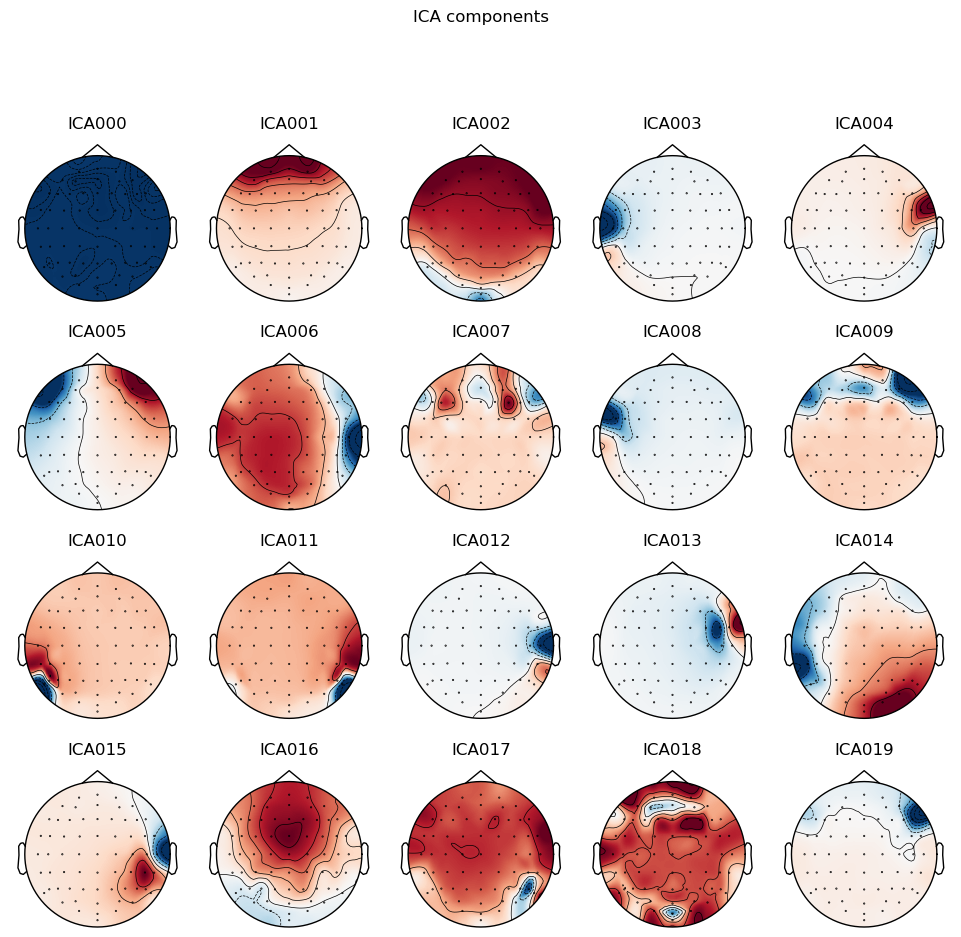

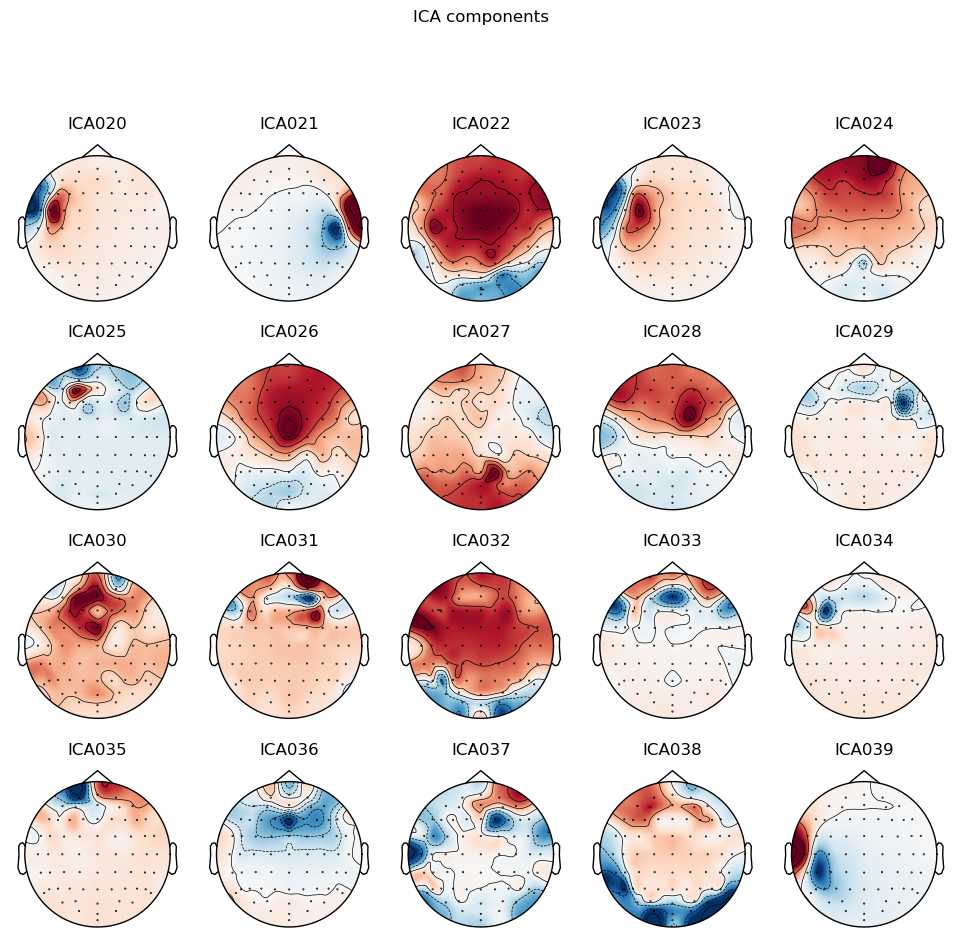

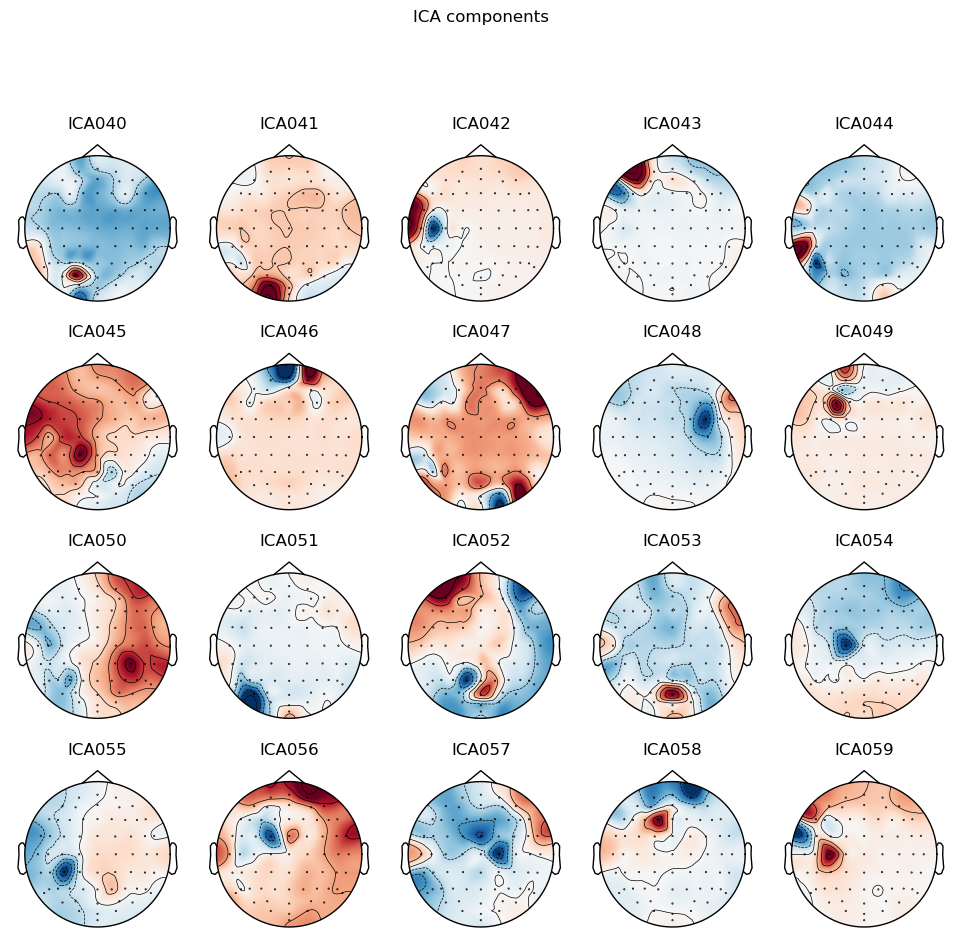

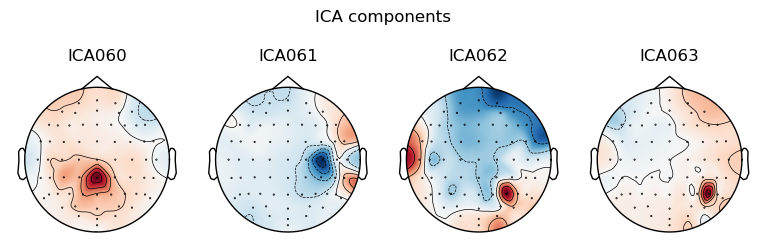

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [69]:
plt.clf()
g = ica.plot_components()

In [ ]:
explained_var_ratio = {i: ica.get_explained_variance_ratio(p1_t, components=[i])['eeg'] for i in range(n_components)} # 1min
fig, ax = plt.subplots(figsize=(10,5))
t = pd.Series(explained_var_ratio)
t.plot(ax=ax)
t.cumsum().plot(ax=ax)
plt.show()

#### Save ICA
If saved after labelling components, then components are saved in `ica.labels_`

In [89]:
# must save with full path
t1_path = os.path.join(eeg_folder, cfile.replace('raw','t1-ica'))
ica.save(t1_path) # 87kB
if os.path.exists(t1_path):
    ica = mne.preprocessing.read_ica(t1_path)

Writing ICA solution to /Users/eliot/Documents/projects/brainkt-expe/notebooks/../data/eeg-aligned/bkt-221215-AGET-p2-t1-ica.fif...
Reading ../data/eeg-aligned/bkt-221215-AGET-p2-t1-ica.fif ...
Now restoring ICA solution ...
Ready.


#### Label Components

In [94]:
ic_labels = label_components(p1_t, ica, method="iclabel")

icl = pd.DataFrame({k:v for k,v in zip(['ica','label','proba'],[range(len(ic_labels["labels"])), ic_labels["labels"], ic_labels["y_pred_proba"]])})
icl.sort_values(['label','proba'], ascending=[True,False], inplace=True)
icl[icl.label.isin(['heart beat','eye blink', 'channel noise','muscle artifact'])]

# Adding from MNE
#ica.find_bads_ecg()
#ica.find_bads_eog(d, '1-EXG1')
icc, probs = ica.find_bads_muscle(p1_t)
#ica._find_bads_ch(d)
icl['mne-muscle'] = None
icl['mne-muscle-prob'] = probs
icl.loc[icc, 'mne-muscle'] = 'muscle'

Effective window size : 0.125 (s)


In [95]:
icl # mne proba don't make much sense

ica            label     proba mne-muscle  mne-muscle-prob
12   12            brain  0.999067       None         0.000180
22   22            brain  0.989186       None         0.004182
60   60            brain  0.985170       None         0.620323
15   15            brain  0.985158       None         0.630294
45   45            brain  0.949825       None         0.000879
51   51            brain  0.895614       None         0.040817
9     9            brain  0.885771       None         0.823126
59   59            brain  0.667371       None         0.363165
43   43            brain  0.527947       None         0.658007
53   53            brain  0.518707       None         0.004810
17   17            brain  0.483673     muscle         0.678112
44   44            brain  0.391949       None         0.087382
50   50    channel noise  0.688302     muscle         0.000365
48   48    channel noise  0.451727       None         0.687208
56   56    channel noise  0.363027       None         0.844616
4     4        eye blink  0.998839       None         0.000372
0     0        eye blink  0.993536       None         0.336323
5     5        eye blink  0.882543       None         0.512300
34   34        eye blink  0.645868       None         0.819725
54   54        eye blink  0.569977     muscle         0.508952
26   26        eye blink  0.568946     muscle         0.842877
31   31        eye blink  0.508699     muscle         0.421011
11   11        eye blink  0.307338       None         0.002363
1     1       heart beat  0.843650       None         0.068089
6     6  muscle artifact  0.998780     muscle         0.409123
8     8  muscle artifact  0.975579     muscle         0.409871
13   13  muscle artifact  0.971311     muscle         0.133164
10   10  muscle artifact  0.965216     muscle         0.054985
3     3  muscle artifact  0.947432     muscle         0.433037
2     2  muscle artifact  0.901467     muscle         0.055749
18   18  muscle artifact  0.886002     muscle         0.417733
14   14  muscle artifact  0.728648     muscle         0.176253
25   25  muscle artifact  0.679299     muscle         0.014260
20   20  muscle artifact  0.507487     muscle         0.004614
19   19  muscle artifact  0.439371     muscle         0.080492
40   40  muscle artifact  0.397766     muscle         0.054905
24   24  muscle artifact  0.330176     muscle         0.037662
28   28  muscle artifact  0.319929     muscle         0.012131
49   49            other  0.898657       None         0.023001
36   36            other  0.864920       None         0.347655
30   30            other  0.848110     muscle         0.711991
47   47            other  0.786191       None         0.016070
16   16            other  0.782805     muscle         0.035074
27   27            other  0.762062       None         0.015715
38   38            other  0.701337       None         0.067595
23   23            other  0.700637       None         0.010110
63   63            other  0.697201       None         0.025622
29   29            other  0.677374       None         0.024259
35   35            other  0.638763       None         0.029552
21   21            other  0.628891     muscle         0.054799
61   61            other  0.595024       None         0.299294
33   33            other  0.592141       None         0.021961
37   37            other  0.587296       None         0.011202
41   41            other  0.581879       None         0.109614
32   32            other  0.560627       None         0.257680
57   57            other  0.550643       None         0.103092
46   46            other  0.463387       None         0.034740
62   62            other  0.449780       None         0.075986
55   55            other  0.421092       None         0.153014
42   42            other  0.393814       None         0.023267
7     7            other  0.387510     muscle         0.012834
39   39            other  0.354517     muscle         0.029654
52   52            other  0.324526 

In [96]:
Counter(ic_labels["labels"])

Counter({'eye blink': 8,
         'heart beat': 1,
         'muscle artifact': 14,
         'other': 26,
         'brain': 12,
         'channel noise': 3})

In [97]:
icl.sort_values('ica').groupby('label').agg({'ica':list})

ica
label                                                                                                                   
brain                                                                    [9, 12, 15, 17, 22, 43, 44, 45, 51, 53, 59, 60]
channel noise                                                                                               [48, 50, 56]
eye blink                                                                                  [0, 4, 5, 11, 26, 31, 34, 54]
heart beat                                                                                                           [1]
muscle artifact                                                     [2, 3, 6, 8, 10, 13, 14, 18, 19, 20, 24, 25, 28, 40]
other            [7, 16, 21, 23, 27, 29, 30, 32, 33, 35, 36, 37, 38, 39, 41, 42, 46, 47, 49, 52, 55, 57, 58, 61, 62, 63]

In [ ]:
label = 'muscle artifact' # 'heart beat' 'channel noise'
picks = icl[icl.label.isin([label])].ica # >= 20: power spectrum doesn't look like muscle, might be channel
mc_figs = ica.plot_properties(d, picks=picks, psd_args={'fmax':80})#, show=False)
#for fig in zip(mc_figs, picks):
#    fig.savefig(os.path.join(aeeg_folder, os.path.split_ext(eeg_file)[0], task_name, f"ica_{picks.zfill(3)}_{label}.png"))

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=1, n_times=1865073
    Range : 336282 ... 2201354 =    164.200 ...  1074.880 secs
Ready.
Using pyopengl with version 3.1.6
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=1, n_times=1865073
    Range : 336282 ... 2201354 =    164.200 ...  1074.880 secs
Ready.
Using pyopengl with version 3.1.6
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
455 matching events found


/Users/eliot/miniconda3/lib/python3.9/site-packages/mne_icalabel/gui/_label_components.py:215: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  dummy_fig, dummy_axes = plt.subplots(3)


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=1, n_times=1865073
    Range : 336282 ... 2201354 =    164.200 ...  1074.880 secs
Ready.
Using pyopengl with version 3.1.6
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
455 matching events found
No baseline correction applied
0 projection items activated
Creating RawArray with float64 data, n_channels=1, n_times=1865073
    Range : 336282 ... 2201354 =    164.200 ...  1074.880 secs
Ready.
Using pyopengl with version 3.1.6
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
455 matching events found


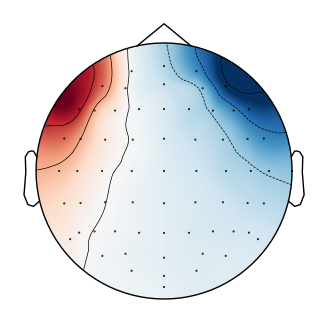

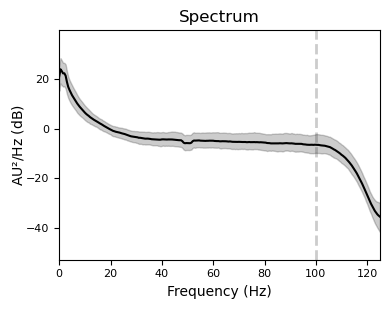

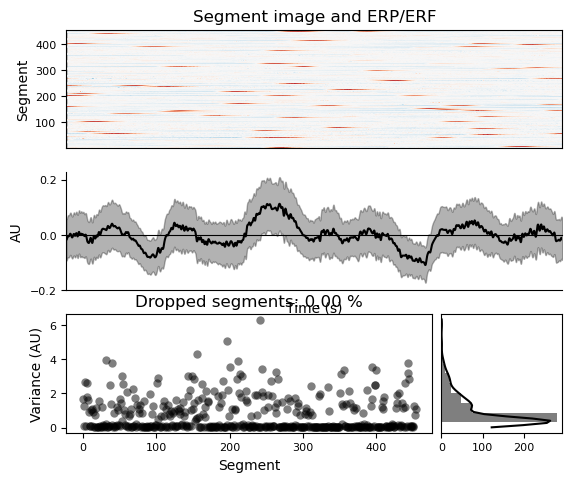

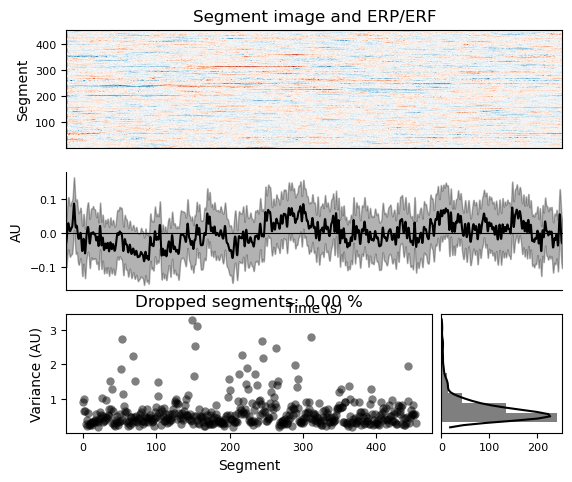

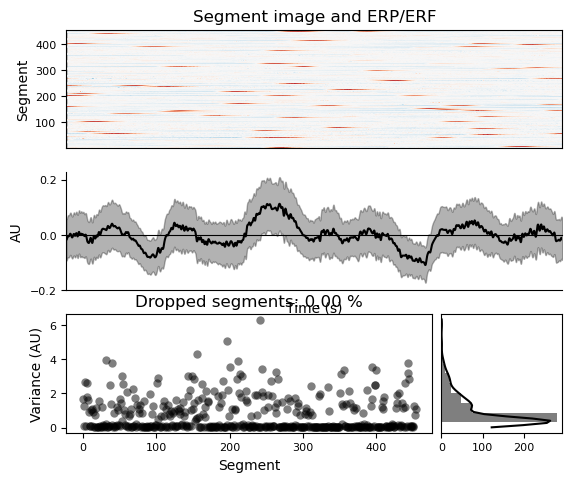

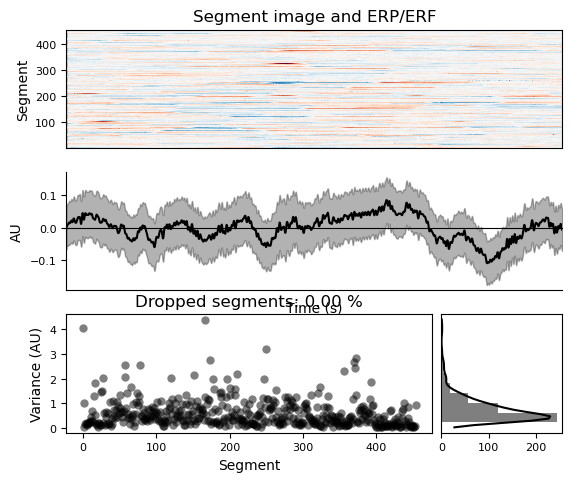

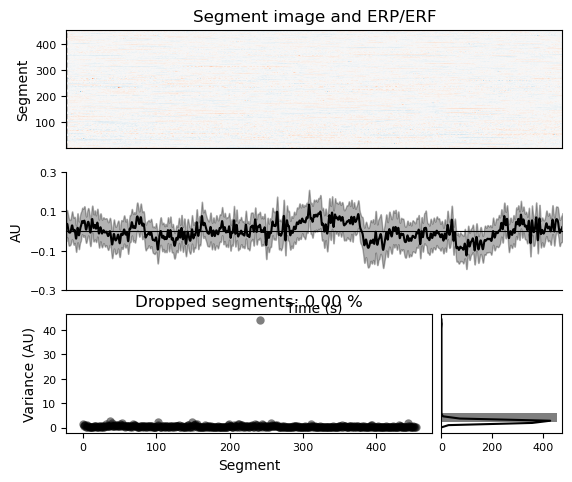

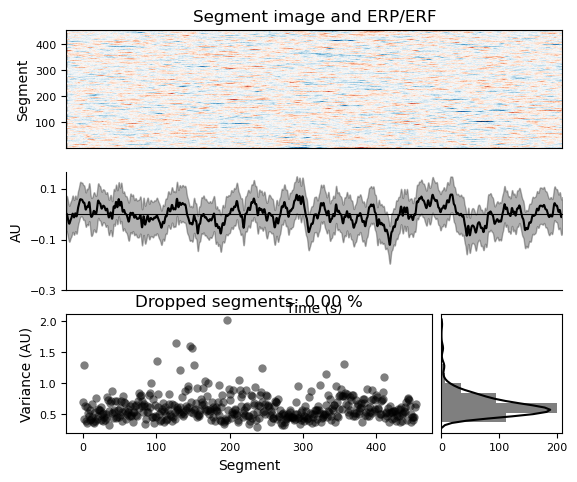

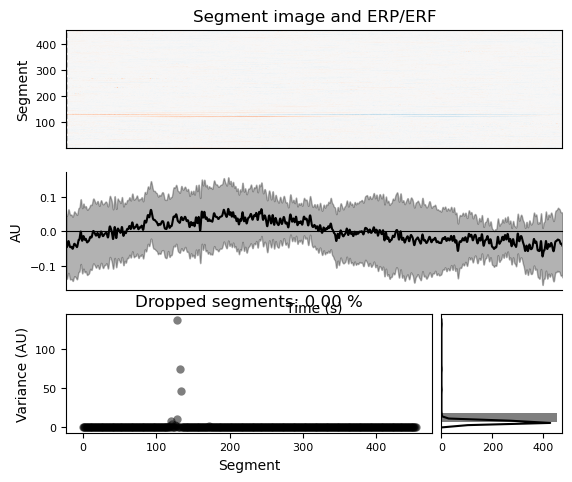

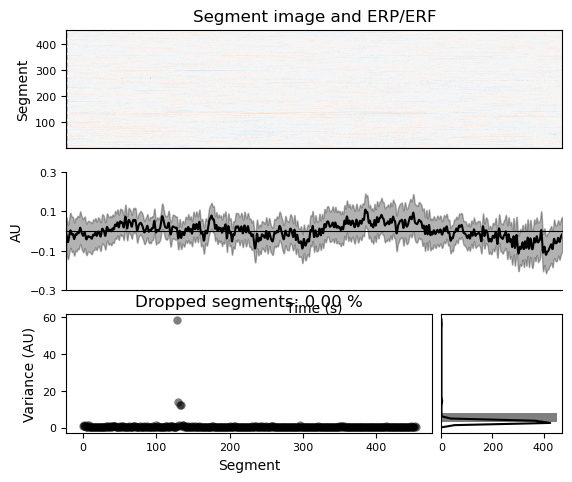

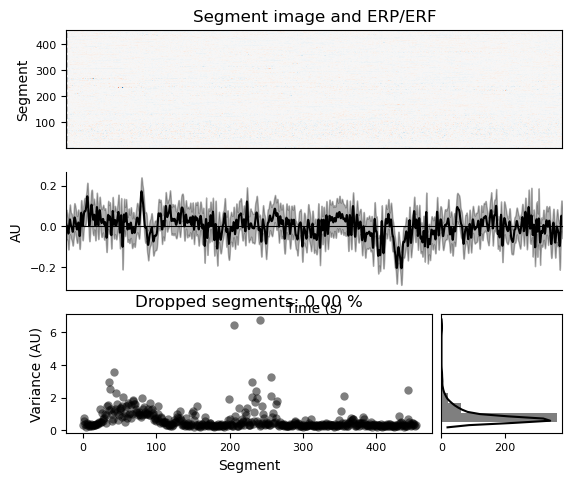

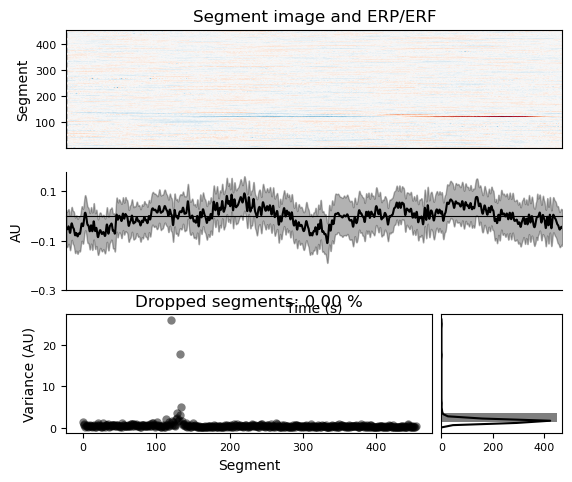

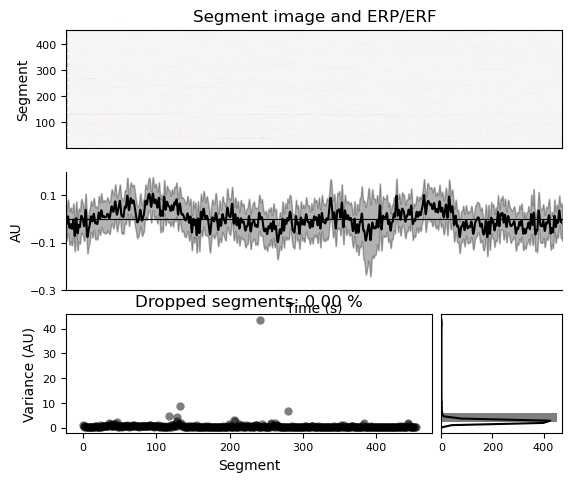

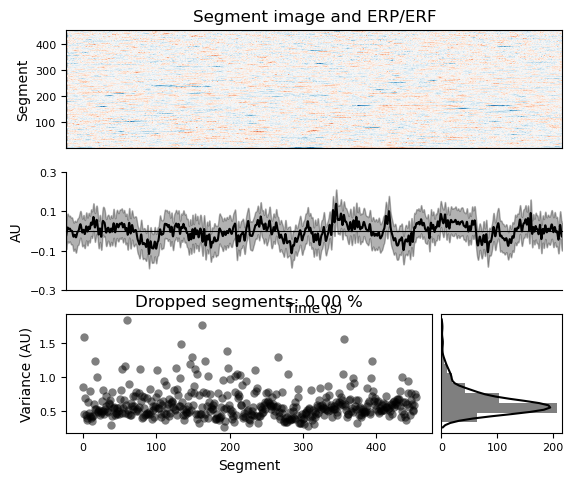

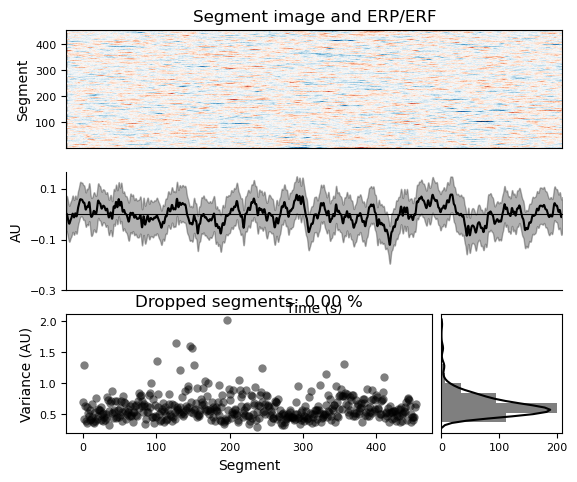

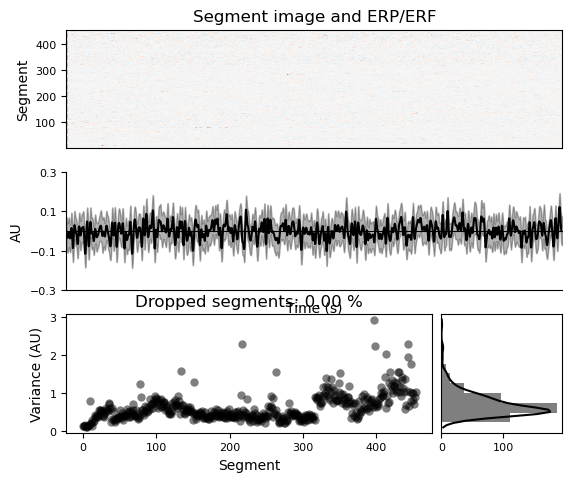

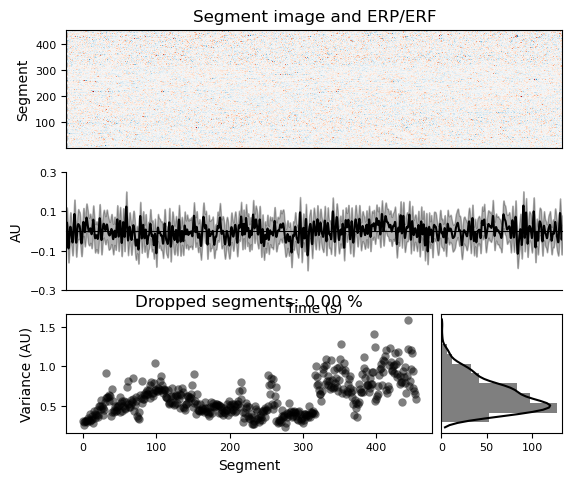

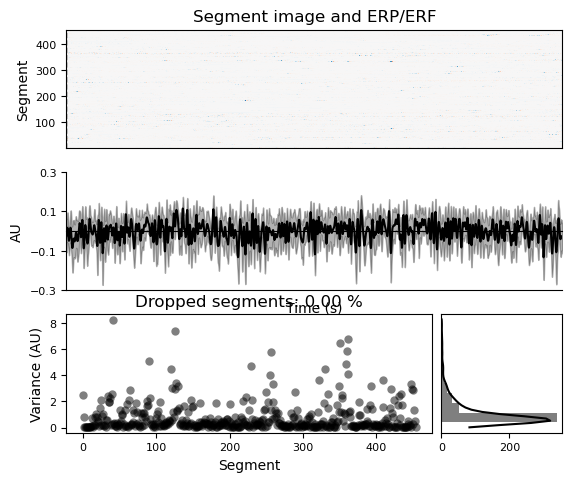

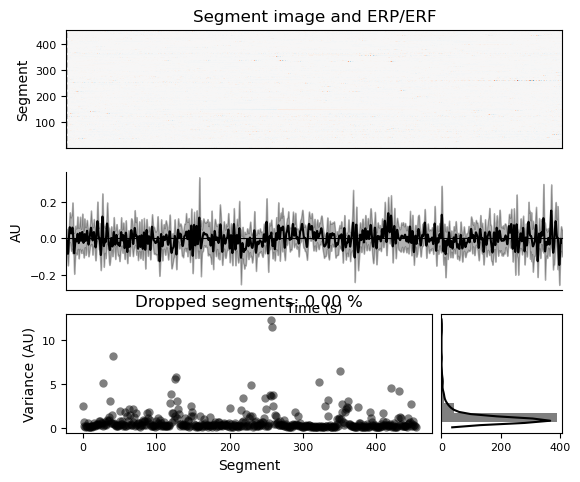

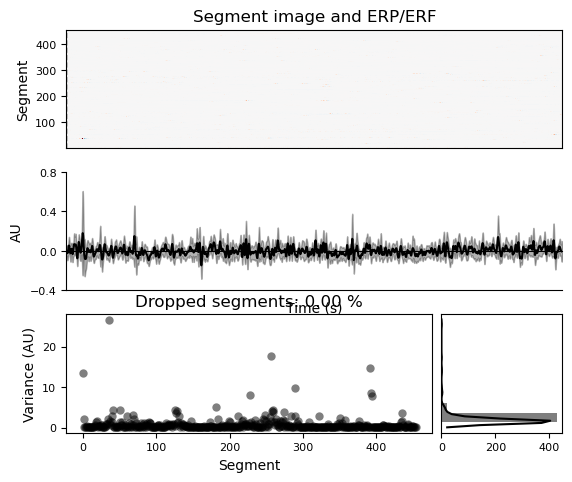

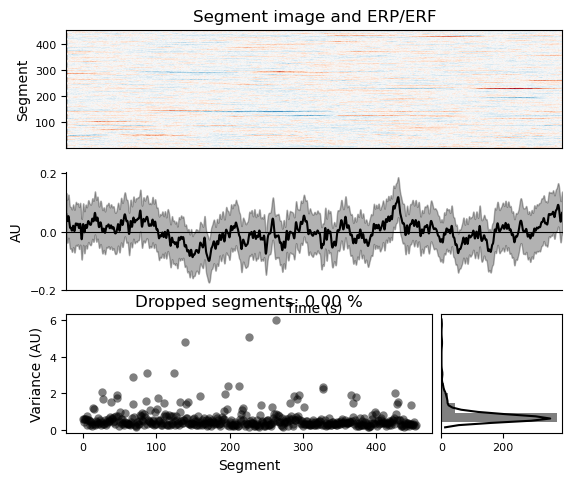

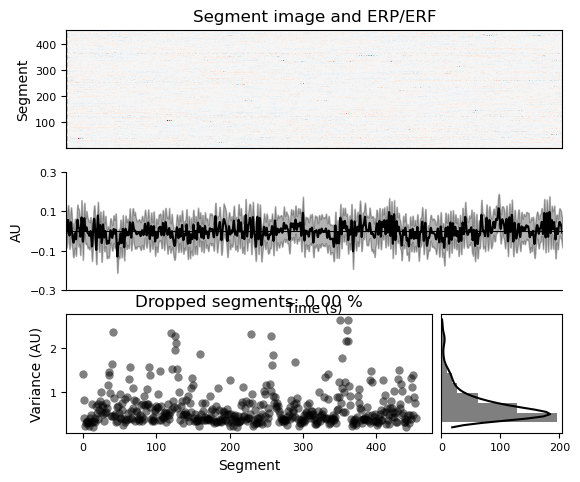

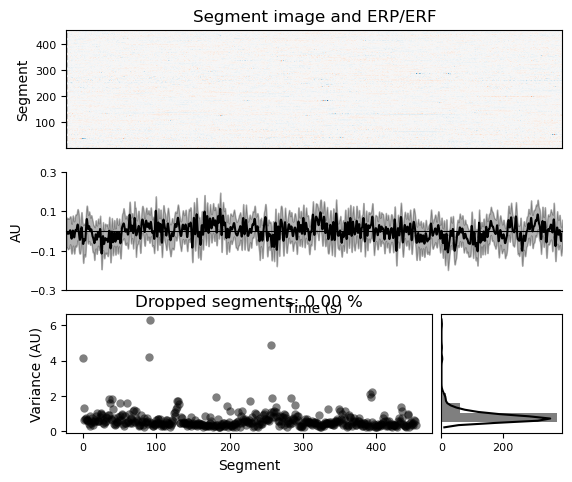

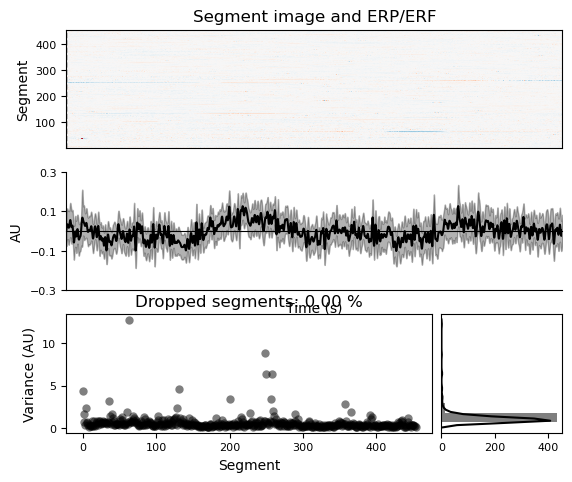

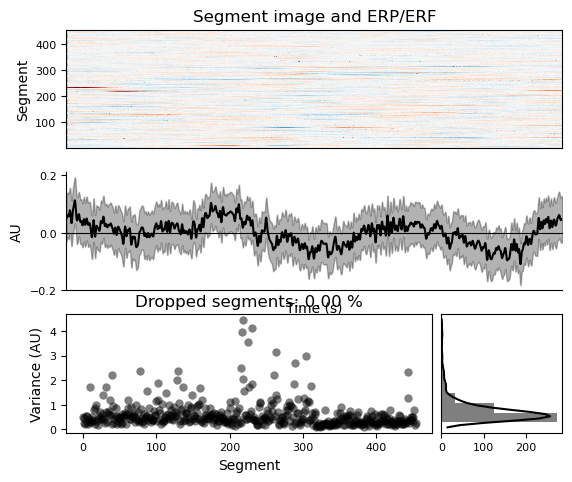

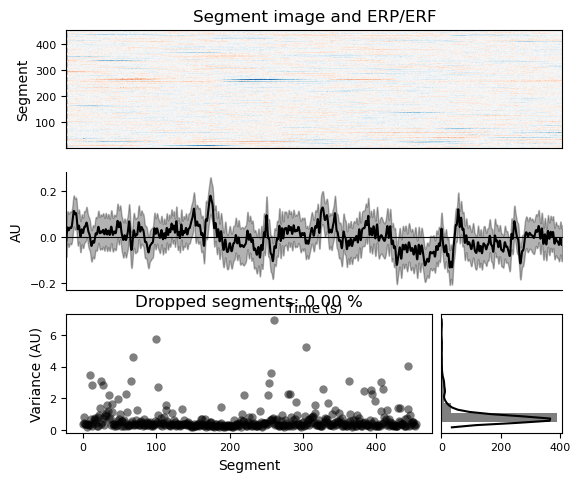

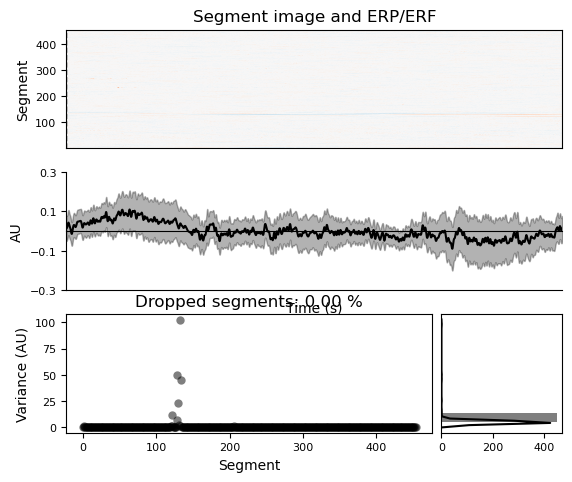

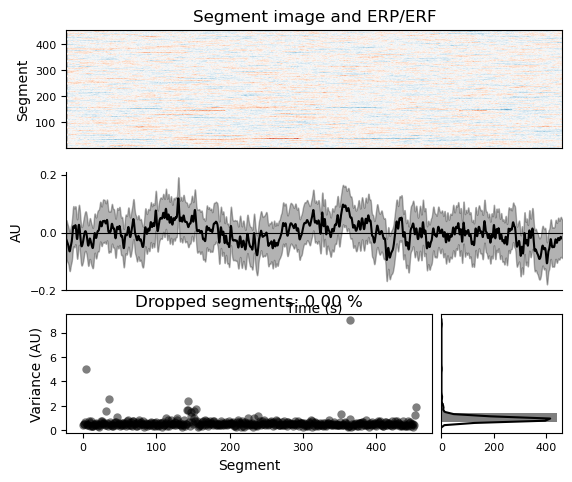

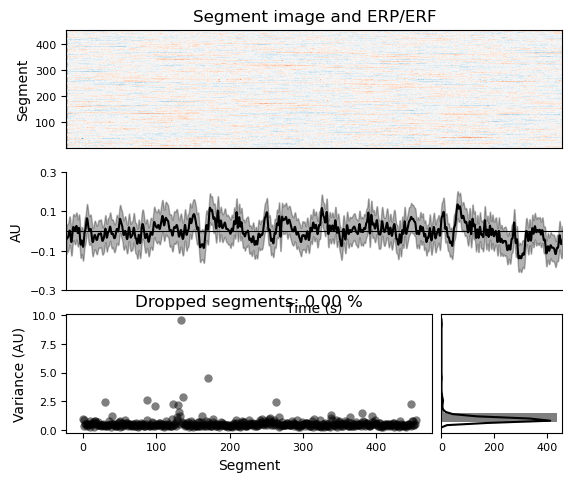

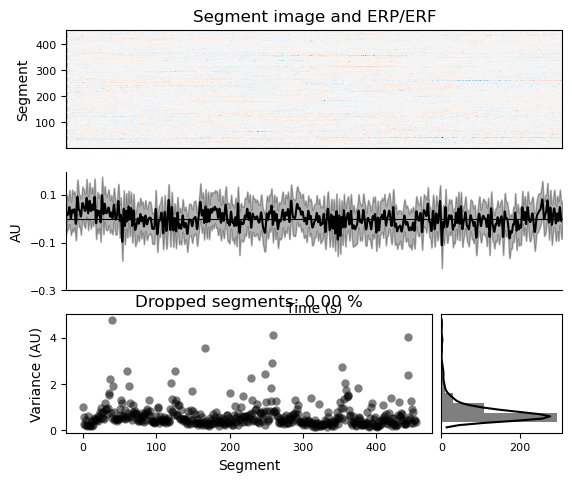

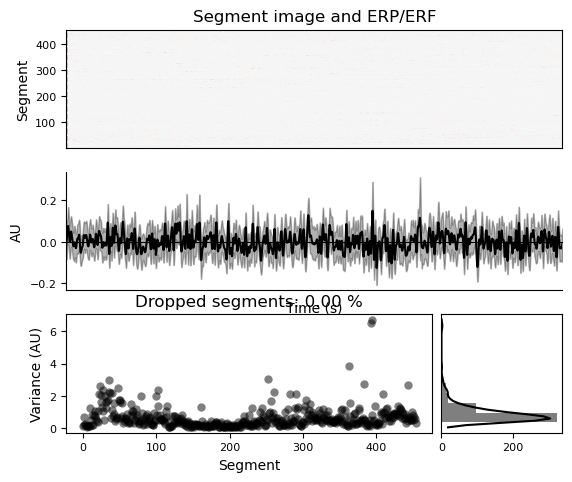

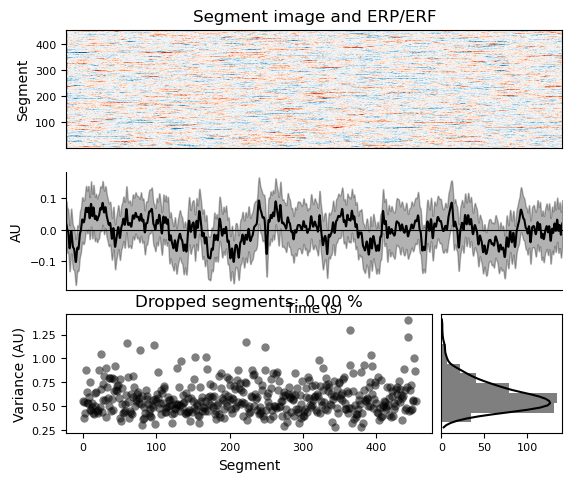

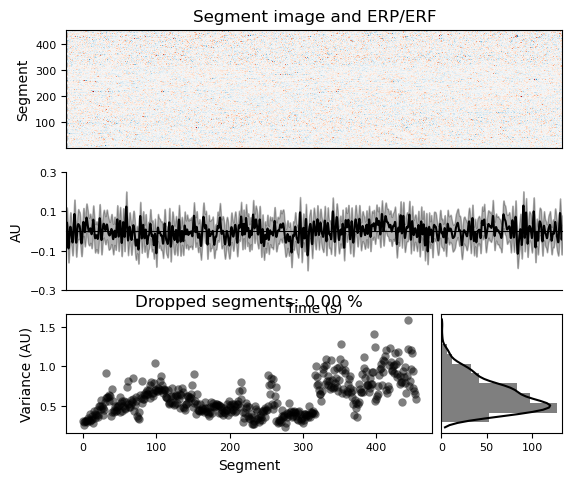

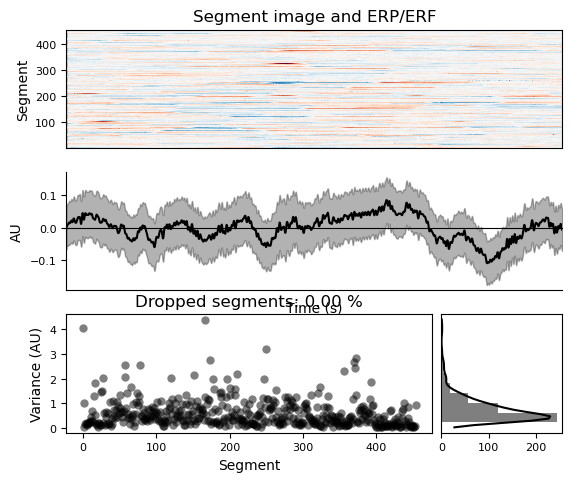

In [98]:
# Check the components
label_ica_components(p1_t, ica, block=True) # effectively update the labels

#### Exclude and recompute EEG data

In [264]:
ica.labels_.keys()

dict_keys(['brain', 'muscle', 'eog', 'ecg', 'line_noise', 'ch_noise', 'other'])

In [268]:
#exclude_idx = icl[(~icl.label.isin(['brain','other'])) & (icl.proba > 0.5)].ica.tolist()
exclude_idx = sorted([y for k,v in ica.labels_.items() if k in ['muscle', 'eog', 'ecg', 'line_noise', 'ch_noise'] for y in v])
keep_idx = sorted([y for k,v in ica.labels_.items() if k not in ['muscle', 'eog', 'ecg', 'line_noise', 'ch_noise'] for y in v])
print(f"Proposing excluding these ICA components: {exclude_idx}\nProposing keeping these components: {keep_idx}")

Proposing excluding these ICA components: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 20, 21, 23, 25, 29, 29, 31, 33, 34, 34, 35, 35, 39, 41, 42, 43, 44, 46, 48, 49, 51, 56, 58, 58, 59, 59, 61]
Proposing keeping these components: [0, 2, 6, 7, 14, 16, 17, 18, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 36, 37, 38, 40, 43, 45, 47, 48, 50, 52, 53, 54, 55, 57, 60, 61, 62, 63]


In [ ]:
#ica.plot_sources(d, show_scrollbars=False)

In [91]:
ica.exclude = exclude_idx
ica.apply(p1_t)

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 25 ICA components
    Projecting back using 64 PCA components


<Raw | bkt-221118-GDNF-p2-raw.fif, 68 x 1657079 (809.1 s), ~859.8 MB, data loaded>

In [194]:
p1_t.plot(n_channels=64, scalings={'eeg':100e-6}) # checking

Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [240]:
# adding stim channels as annotations for output
#trig_annot = mne.annotations_from_events(mne.find_events(p1_t2, stim_channel='Status'), 
#                                         sfreq = p1_t2.info['sfreq'], event_desc={65536:'EEG start', 1:'Audio Trigger'})
#if len(p1_t2.annotations) == 0:
#    p1_t2.set_annotations(trig_annot) 
#else:
#    # already has annotations so cannot _set_, rather _add_ new annotations
#    p1_t2.annotations + trig_annot
#    add_annotations(data, {'audio_trig': trig_annot.to_data_frame()})
# not adding triggers as annotations as:
#   1. triggers are not exactly linked to split tasks, they are used to align, mark is used to split tasks
#   2. datetime issues

In [96]:
out_file = os.path.join(oeeg_folder, cfile.replace('raw.fif','t1.edf'))
mne.export.export_raw(out_file, p1_t1, add_ch_type=False, overwrite=True) # stim channels are dropped as not in voltage => need by tasks

/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_44627/4156100099.py:2: RuntimeWarning: EDF format requires equal-length data blocks, so 0.87939453125 seconds of zeros were appended to all channels when writing the final block.
  mne.export.export_raw(out_file, p1_t1, add_ch_type=False, overwrite=True)


Checking data can be read correctly:

In [190]:
mne.viz.set_browser_backend('qt')
raw = mne.io.read_raw_edf(out_file)
raw.plot(n_channels=64, scalings={'eeg':100e-6})
# ok; stim missing but annotations still there

Using qt as 2D backend.
Extracting EDF parameters from /Users/eliot/Documents/projects/brainkt-expe/data/eeg-task-cleaned/bkt-221118-GDNF-p2-t1-ica.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/kr/m6yb8cr154dcdkxnm75b4clw0000gn/T/ipykernel_44627/3690304917.py:3: RuntimeWarning: Omitted 34 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(out_file)


Using pyopengl with version 3.1.6


Channels marked as bad:
none


#### Cleaning up

In [ ]:
del p1_t

In [ ]:
del p1

## Other tests
Loading - computing envelope - Downsampling envelope - Downsampling EEG

In [58]:
import torchaudio

In [ ]:
def read_audioarr_from_file(path, target_sampling_rate=128):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy() # no need
    return speech